In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [133]:
#importing file
df = pd.read_excel('../data/proshares_analysis_data.xlsx', sheet_name='hedge_fund_series', index_col=0)
df.head()

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
2011-08-31,-0.032149,-0.025588,-0.025689,-0.027036,-0.006489
2011-09-30,-0.038903,-0.032414,-0.032593,-0.032466,-0.022141
2011-10-31,0.026858,0.043593,0.043320,0.050531,0.025239
2011-11-30,-0.013453,-0.012142,-0.012431,-0.028608,-0.007964
2011-12-31,-0.004479,0.001938,0.001796,0.012875,0.001822


1)

In [134]:
#calculating summary statistics
summary_stats = df.describe().iloc[1:3]
summary_stats.loc['mean'] *= 12
summary_stats.loc['std'] *= 12**0.5
summary_stats.loc['sharpe'] = summary_stats.loc['mean'] / summary_stats.loc['std']
summary_stats

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
mean,0.048295,0.036286,0.034605,0.024812,0.025653
std,0.059476,0.056136,0.055980,0.058408,0.050009
sharpe,0.812004,0.646398,0.618172,0.424805,0.512971


2)

In [135]:
#calculating further statistics
summary_stats.loc['skewness'] = df.skew()
summary_stats.loc['kurtosis'] = df.kurtosis()
summary_stats.loc['VaR (.05)'] = df.quantile(.05)
summary_stats.loc['CVaR (.05)'] = df.apply(lambda x: x[x <= x.quantile(.05)].mean())
summary_stats

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
mean,0.048295,0.036286,0.034605,0.024812,0.025653
std,0.059476,0.056136,0.055980,0.058408,0.050009
sharpe,0.812004,0.646398,0.618172,0.424805,0.512971
skewness,-0.963318,-0.265394,-0.251279,-0.254201,-0.434775
kurtosis,5.763074,1.631580,1.595863,1.759250,1.605934
VaR (.05),-0.024293,-0.028189,-0.028095,-0.030932,-0.017895
CVaR (.05),-0.037478,-0.035857,-0.035816,-0.037575,-0.032695


In [136]:
#calculating max drawdown
cumulative_returns = (1+df).cumprod()
runningmax = cumulative_returns.cummax()
drawdown = (cumulative_returns - runningmax)/runningmax

def maxdrawdownfunc(series):
    maxdrawdown = drawdown[series.name].min()
    troughdate = drawdown[series.name].idxmin()
    peakdate = runningmax[series.name][:troughdate].idxmax()
    recoverydate = cumulative_returns[series.name][troughdate:].ge(runningmax[series.name].loc[troughdate]).idxmax()

    return pd.Series({
        'Max_Drawdown': maxdrawdown,
        'Peak_Date': peakdate,
        'Trough_Date': troughdate,
        'Recovery_Date': recoverydate
    })

max_drawdown_stats = df.apply(maxdrawdownfunc)
max_drawdown_stats

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
Max_Drawdown,-0.115473,-0.124302,-0.124388,-0.14072,-0.137716
Peak_Date,2019-12-31 00:00:00,2021-06-30 00:00:00,2021-06-30 00:00:00,2021-06-30 00:00:00,2021-06-30 00:00:00
Trough_Date,2020-03-31 00:00:00,2022-09-30 00:00:00,2022-09-30 00:00:00,2022-09-30 00:00:00,2022-09-30 00:00:00
Recovery_Date,2020-08-31 00:00:00,2024-02-29 00:00:00,2024-02-29 00:00:00,2024-07-31 00:00:00,2024-02-29 00:00:00


3.

In [137]:
#import SPY data
df2 = pd.read_excel('../data/proshares_analysis_data.xlsx', sheet_name='merrill_factors', index_col=0)
dfSPY = df2[['SPY US Equity']]
dfSPY.head()

,SPY US Equity
2011-08-31,-0.054976
2011-09-30,-0.069420
2011-10-31,0.109147
2011-11-30,-0.004064
2011-12-31,0.010449


In [138]:
#run a regression against SPY data
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

risk_free_rate = 0.0409
X = sm.add_constant(dfSPY)

def regressionstats(dfcol):
    y = dfcol
    model = sm.OLS(y,X).fit()

    marketbeta = model.params['SPY US Equity']

    avg_return_fund = y.mean()
    avg_return_spy = dfSPY['SPY US Equity'].mean()
    annualized_return_fund = (1 + avg_return_fund)**12 - 1
    treynor_ratio = (annualized_return_fund - risk_free_rate) / marketbeta

    residuals = model.resid
    tracking_error = np.std(residuals)
    information_ratio = (avg_return_fund - avg_return_spy) / tracking_error

    return pd.Series({
        'Market Beta': marketbeta,
        'Treynor Ratio': treynor_ratio,
        'Information Ratio': information_ratio
    })

regression_stats = pd.DataFrame()

for col in df.columns:
    stats = regressionstats(df[col])
    regression_stats[col] = stats


regression_stats = regression_stats.T
regression_stats


,Market Beta,Treynor Ratio,Information Ratio
HFRIFWI Index,0.346131,0.024495,-0.856989
MLEIFCTR Index,0.343383,-0.011662,-1.188357
MLEIFCTX Index,0.342171,-0.016777,-1.207110
HDG US Equity,0.352053,-0.044891,-1.202549
QAI US Equity,0.298376,-0.050081,-1.351285


4)

- The hedge fund series appear to be less correlated to the market, as they have betas of .35 and lower. Hoever, their Treynore and Information Ratios are all low, which indicates they are underperforming compared to SPY in general.
- HDG is performing better across the Treynor and Information Ratio metrics, altho it is slighty more correlated to SPY from having a higher Beta
- HDG and the ML series do not capture the notable properties of HFRI, as HFRI has a better (though still negative) Information Ratio and a positive Treynor Ratio. This suggests that HFRI is at least generating some positive risk-adjusted returns, which HDG and ML series fail to replicate.

5)

<Axes: >

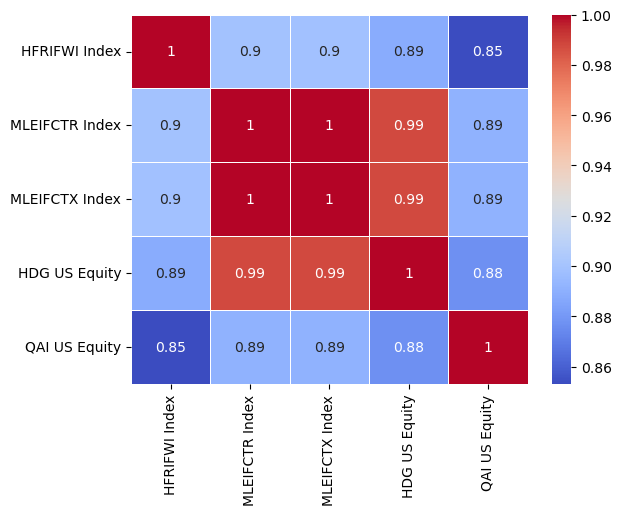

In [139]:
#getting correlation data

import seaborn as sns
corrmatrix = df.corr()
sns.heatmap(corrmatrix, annot=True, cmap='coolwarm', linewidths=0.5)


MFLEIFCTX and MLEIFCTR seem to have the highest correlation, while QAI and HFRIFWI have the lowest.

6)

In [140]:
y = df['HFRIFWI Index']
X = sm.add_constant(df2)
model = sm.OLS(y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          HFRIFWI Index   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     131.8
Date:                Sun, 13 Oct 2024   Prob (F-statistic):           1.99e-57
Time:                        12:43:10   Log-Likelihood:                 563.14
No. Observations:                 158   AIC:                            -1112.
Df Residuals:                     151   BIC:                            -1091.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0012      0.001      1.702      0.091      -0.000       0.003
SPY US Equity     0.0365      0.034      1.072      0.286      -0.031       0.104
USGG3M Index      0.1463      0.376      0.389      0.698      -0.596       0.889
EEM US Equity     0.0816      0.020      4.049      0.000       0.042       0.121
EFA US Equity     0.0846      0.034      2.473      0.015       0.017       0.152
EUO US Equity     0.0288      0.017      1.701      0.091      -0.005       0.062
IWM US Equity     0.1451      0.020      7.103      0.000       0.105       0.185
==============================================================================
Omnibus:                       24.101   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               84.919
Skew:                          -0.458   Prob(JB):                     3.63e-19
Kurtosis:                       6.473   Cond. No.                         674.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [141]:
tracking_error = model.resid.std()
print(tracking_error)

0.00687466807687868


The betas all seem to be reasonable and do not require any oversized long-short positions.

7)

In [142]:
df

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
2011-08-31,-0.032149,-0.025588,-0.025689,-0.027036,-0.006489
2011-09-30,-0.038903,-0.032414,-0.032593,-0.032466,-0.022141
2011-10-31,0.026858,0.043593,0.043320,0.050531,0.025239
2011-11-30,-0.013453,-0.012142,-0.012431,-0.028608,-0.007964
2011-12-31,-0.004479,0.001938,0.001796,0.012875,0.001822
...,...,...,...,...,...
2024-05-31,0.014100,0.010610,0.010280,0.011225,0.013480
2024-06-30,-0.000300,0.001292,0.001114,-0.001986,0.003188
2024-07-31,0.012700,0.023803,0.023166,0.024381,0.011279
2024-08-31,0.002500,-0.000733,-0.000766,-0.002413,0.007648


In [143]:
df2

,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity
2011-08-31,-0.054976,0.000009,-0.092549,-0.087549,-0.005889,-0.088913
2011-09-30,-0.069420,0.000017,-0.179063,-0.108082,0.142180,-0.111505
2011-10-31,0.109147,-0.000013,0.162986,0.096274,-0.069502,0.151011
2011-11-30,-0.004064,0.000000,-0.019724,-0.021765,0.054627,-0.003784
2011-12-31,0.010449,0.000009,-0.042649,-0.021744,0.075581,0.005144
...,...,...,...,...,...,...
2024-05-31,0.050580,0.004501,0.019517,0.050603,-0.028355,0.050383
2024-06-30,0.035280,0.004462,0.026176,-0.018270,0.032101,-0.011243
2024-07-31,0.012109,0.004403,0.008453,0.025916,-0.016610,0.103356
2024-08-31,0.023365,0.004260,0.009779,0.032603,-0.035513,-0.016885


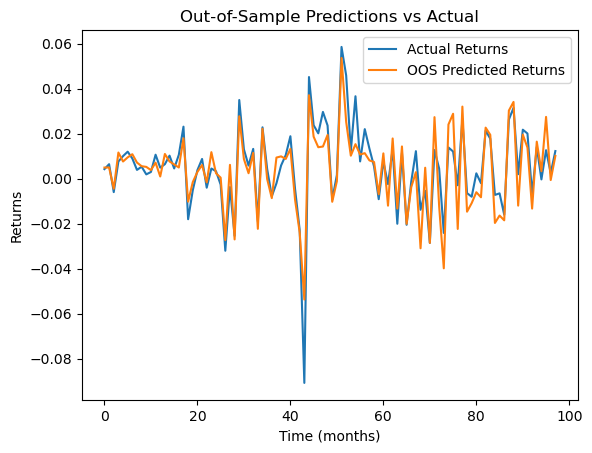

In [144]:
# Rolling window regression
window = 60
oos_predictions = []
actuals = []

for t in range(window, len(df)):

    train_data1 = df.iloc[t-window:t] 
    train_data2 = df2.iloc[t-window:t] 
    
    X_train = sm.add_constant(train_data2)
    y_train = train_data1['HFRIFWI Index']
    
    model = sm.OLS(y_train, X_train).fit()
    
    X_t = df2.iloc[t].values.reshape(1, -1)
    X_t = sm.add_constant(X_t, has_constant='add')

    oos_prediction = model.predict(X_t)[0]
    oos_predictions.append(oos_prediction)
    
    actuals.append(df.iloc[t]['HFRIFWI Index'])

oos_predictions = np.array(oos_predictions)
actuals = np.array(actuals)

plt.plot(actuals, label='Actual Returns')
plt.plot(oos_predictions, label='OOS Predicted Returns')
plt.legend()
plt.title('Out-of-Sample Predictions vs Actual')
plt.xlabel('Time (months)')
plt.ylabel('Returns')
plt.show()

In [145]:
mse = np.mean((oos_predictions - actuals)**2)
mse

6.960179196296026e-05

The mean squared error is quite low, and we can assess the replication as being fairly accurate.

8)

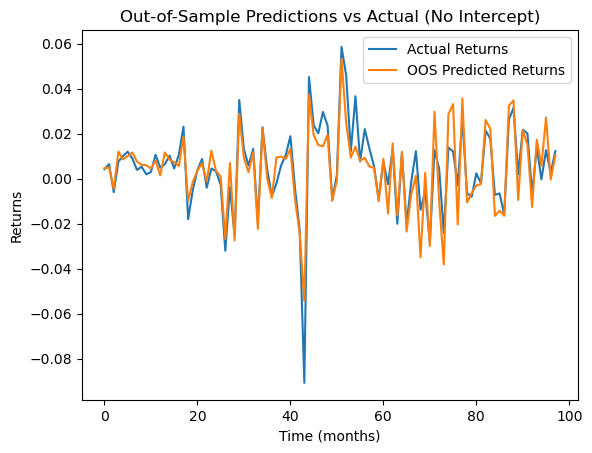

In [146]:
#Rolling window regression with no intercept

window = 60
oos_predictions = []
actuals = []

for t in range(window, len(df)):

    train_data1 = df.iloc[t-window:t] 
    train_data2 = df2.iloc[t-window:t] 
    
    X_train = train_data2
    y_train = train_data1['HFRIFWI Index']
    
    model = sm.OLS(y_train, X_train).fit()
    
    X_t = df2.iloc[t].values.reshape(1, -1)

    oos_prediction = model.predict(X_t)[0]
    oos_predictions.append(oos_prediction)
    
    actuals.append(df.iloc[t]['HFRIFWI Index'])

oos_predictions = np.array(oos_predictions)
actuals = np.array(actuals)

plt.plot(actuals, label='Actual Returns')
plt.plot(oos_predictions, label='OOS Predicted Returns')
plt.legend()
plt.title('Out-of-Sample Predictions vs Actual (No Intercept)')
plt.xlabel('Time (months)')
plt.ylabel('Returns')
plt.show()

In [147]:
mse = np.mean((oos_predictions - actuals)**2)
mse

7.201581141952289e-05

Both of these approaches have low MSEs. Therefore, its not clear whether they used an intercept or not. However, it is safe to assume they did use one as the MSE is slightly lower in that scenario, and using an intercept tends to make models more flexible/accurate.